# Define MHWs using [Hobday definition](https://doi.org/10.1016/j.pocean.2015.12.014)
(>=5 consecutive days w/ a gap of >=3 days in between events)

In [1]:
import xarray as xr
import pandas as pd
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.stats import linregress
from xrft import detrend
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
import matplotlib.dates as mdates
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
import geopandas as gpd
import regionmask
import gsw
import marineHeatWaves as mhw

In [2]:
gpath = '/work5/stb/MHW-gfdl/Collab-LG_SS/cmems_mod_glo_phy_my_0.083deg_P1M-m_so-thetao_98.00W-80.00W_17.00N-31.00N_0.49-5727.92m_1993-01-01-2025-08-01.nc'
#esm4_path = '/work5/stb/ESM4/historical_1850-2014/ts/ocean_monthly_z.*.*.nc'
oisst_path = '/work5/stb/MHW-gfdl/Collab-LG_SS/OISST_gom_1981-2025_daily_sst.nc'
era_path = '/work/Shanice.Bailey/MHW-gfdl/compare_avgs_trends/ERA5/ds_era5.nc'

cora = xr.open_dataset('/work5/stb/MHW-gfdl/cora.nc', chunks={})
glorys_ds = xr.open_dataset(gpath, chunks={})
#ds_z = xr.open_mfdataset(esm4_path, chunks={}, decode_timedelta=True)
oisst_ds = xr.open_dataset(oisst_path)#, chunks={})
era = xr.open_dataset(era_path, chunks={})

## Try Oliver's `mhw` package

In [3]:
oisst_ds

<xarray.Dataset> Size: 303MB
Dimensions:  (time: 16101, lon: 84, lat: 56)
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon      (lon) float32 336B 260.1 260.4 260.6 260.9 ... 280.4 280.6 280.9
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
Data variables:
    sst      (time, lat, lon) float32 303MB ...
Attributes:
    CDI:            Climate Data Interface version 1.9.10 (https://mpimet.mpg...
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    institution:    NOAA/NCDC
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...
    CDO:            Climate Data Operators version 1.9.10 (https://mpimet.mpg...
    history:        01-Oct-2025 11:40:12 Subset NOAA/PSL

In [4]:
oisst_ds.time

<xarray.DataArray 'time' (time: 16101)> Size: 129kB
array(['1981-09-01T00:00:00.000000000', '1981-09-02T00:00:00.000000000',
       '1981-09-03T00:00:00.000000000', ..., '2025-09-28T00:00:00.000000000',
       '2025-09-29T00:00:00.000000000', '2025-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T
    actual_range:   [66352. 82452.]

In [5]:
from datetime import date
# Generate time vector using datetime format (January 1 of year 1 is day 1)
t = np.arange(date(1982,1,1).toordinal(),date(2014,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]
# Generate synthetic temperature time series
sst = np.zeros(len(t))
sst[0] = 0 # Initial condition
a = 0.85 # autoregressive parameter
for i in range(1,len(t)):
    sst[i] = a*sst[i-1] + 0.75*np.random.randn() + 0.5*np.cos(t[i]*2*np.pi/365.25)
sst = sst - sst.min() + 5.

mhws, clim = mhw.detect(t,sst)

AttributeError: `np.NaN` was removed in the NumPy 2.0 release. Use `np.nan` instead.

In [4]:
mhws, clim = mhw.detect(oisst_ds.time, oisst_ds.sst)

TypeError: 'DataArray' object cannot be interpreted as an integer

## Manual Detection

|  | OISST | CORA | GLORYS | ERA5 | SPEAR |
| :----------: | :----------: | :----------: | :----------: | :----------: | :----------: |
| Temperature | SST | 3D | 3D | SST |
| Sampling<br>frequency | Daily | Monthly | Monthly | Daily |   |
| Lat/Lon<br>resolution | 0.25˚ x 0.25˚ | 0.1˚ x 0.5˚ | 1/12˚ x 1/12˚ | 0.25˚ x 0.25˚ |   |
|Time period | 1981-09 : 2025-09 | 1980-01 : 2024-06 | 1993-01 : 2025-08 | 1983-01 : 2021-06 |   |

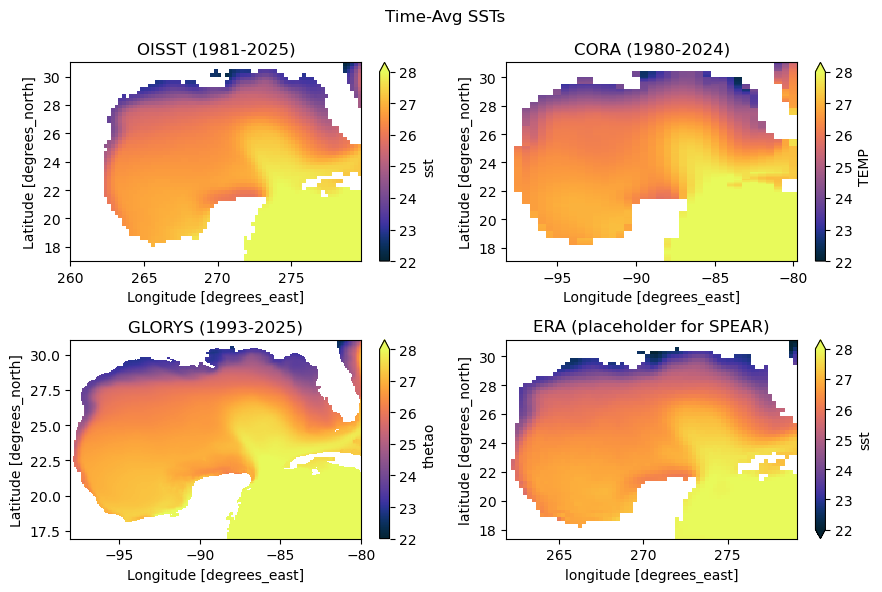

In [4]:
fig, ax = plt.subplots(2,2, figsize=(9,6))
oisst.mean('time').plot(ax=ax[0,0], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[0,0].set_title('OISST (1981-2025)')
cora.TEMP.isel(depth=0).mean('time').plot(ax=ax[0,1], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[0,1].set_title('CORA (1980-2024)')
glorys_ds.thetao.isel(depth=0).mean('time').plot(ax=ax[1,0], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[1,0].set_title('GLORYS (1993-2025)')
era.sst.mean('time').plot(ax=ax[1,1], cmap=cmocean.cm.thermal, vmin=22, vmax=28)
ax[1,1].set_title('ERA (placeholder for SPEAR)')
plt.suptitle('Time-Avg SSTs')
plt.tight_layout();

## Detrend

In [3]:
#start w OISST to establish workflow
oisst = oisst_ds.sst.sel(lon=slice(None, 279.625))

In [4]:
#Fits a polynomial to the data along the time dim
p = oisst.polyfit(dim='time', deg=1) #('degree', 'lat', 'lon'){:16101, :56, :79}

#Solves for each element/term in the polynomial (essentially solves for x). Is that right?
fit = xr.polyval(oisst.time, p.polyfit_coefficients) #('time', 'lat','lon'){:16101, :56, :79}

#detrended da along time dim
detrended_intime = oisst - fit 

In [5]:
detrended_intime

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[       nan,        nan,        nan, ..., 0.56249045,
         0.61682021, 0.62065052],
        [       nan,        nan,        nan, ..., 0.73312377,
         0.75378651, 0.81314929],
        [       nan,        nan,        nan, ..., 0.8020876 ,
         0.85973364, 0.94598217],
        ...,
        [       nan,        nan,        nan, ..., 3.10062762,
         2.83790433, 2.88615597],
        [       nan,        nan,        nan, ..., 3.42294399,
         3.08692153, 2.91810974],
        [       nan,        nan,        nan, ..., 3.68840716,
         3.25868274, 2.97429929]],

       [[       nan,        nan,        nan, ..., 0.65242615,
         0.73675493, 0.86058641],
        [       nan,        nan,        nan, ..., 0.89305961,
         0.92372294, 0.98308597],
        [       nan,        nan,        nan, ..., 1.13202354,
         1.12967046, 1.13591725],
...
        [       nan,        nan,        nan, ..., 4.42173669,
         3.7155432 , 2.98889981],
        [       nan,        nan,        nan, ..., 4.68609461,
         3.9964043 , 3.25226161],
        [       nan,        nan,        nan, ..., 5.08845704,
         4.47995499, 3.77025527]],

       [[       nan,        nan,        nan, ..., 1.80490595,
         1.76289759, 1.67217779],
        [       nan,        nan,        nan, ..., 1.85251356,
         1.74903826, 1.60249053],
        [       nan,        nan,        nan, ..., 1.93180052,
         1.76505115, 1.56281654],
        ...,
        [       nan,        nan,        nan, ..., 4.40175307,
         3.78552349, 3.118842  ],
        [       nan,        nan,        nan, ..., 4.68612028,
         4.15639914, 3.512218  ],
        [       nan,        nan,        nan, ..., 5.07849843,
         4.62997146, 4.01023181]]])
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon      (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88

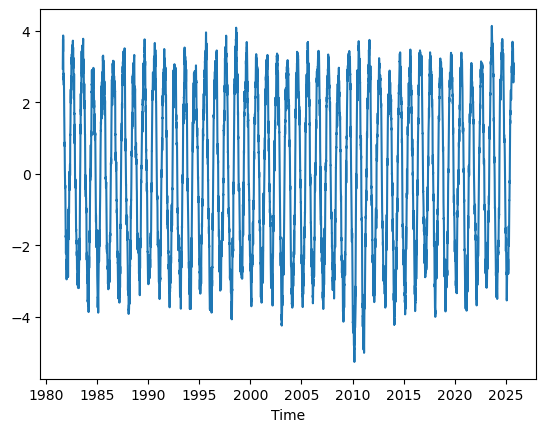

In [7]:
detrended_intime.mean(['lat','lon']).plot()

In [13]:
anom = oisst.groupby('time.day') - oisst.groupby('time.day').mean('time') 

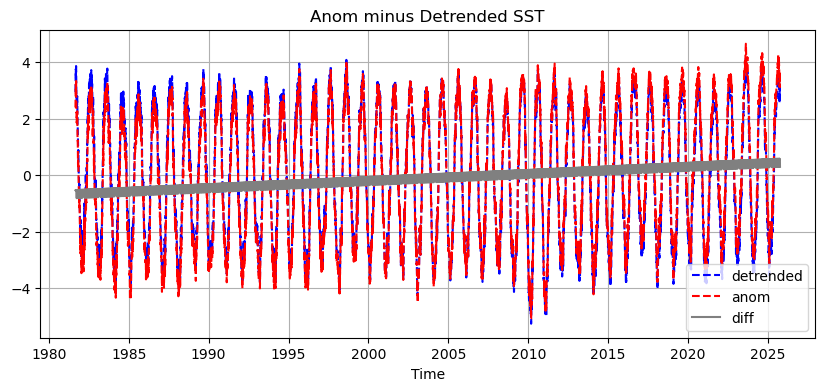

In [14]:
detrended_intime.mean(['lat','lon']).plot(label='detrended', color='b', linestyle='dashed', figsize=(10,4))
anom.mean(['lat','lon']).plot(label='anom', linestyle='dashed', color='r')
(anom.drop_vars('day') - detrended_intime).mean(['lat','lon']).plot(label='diff', color='grey')
plt.legend()
plt.grid()
plt.title('Anom minus Detrended SST');

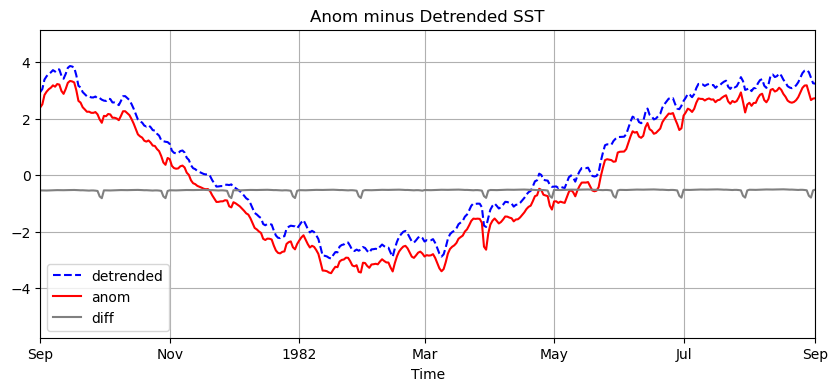

In [15]:
detrended_intime.mean(['lat','lon']).plot(label='detrended', color='b', linestyle='dashed', figsize=(10,4))
anom.mean(['lat','lon']).plot(label='anom', color='r')
(anom.drop_vars('day') - detrended_intime).mean(['lat','lon']).plot(label='diff', color='grey')
plt.legend()
plt.grid()
plt.xlim(detrended_intime.time[0], detrended_intime.time[365])
plt.title('Anom minus Detrended SST');

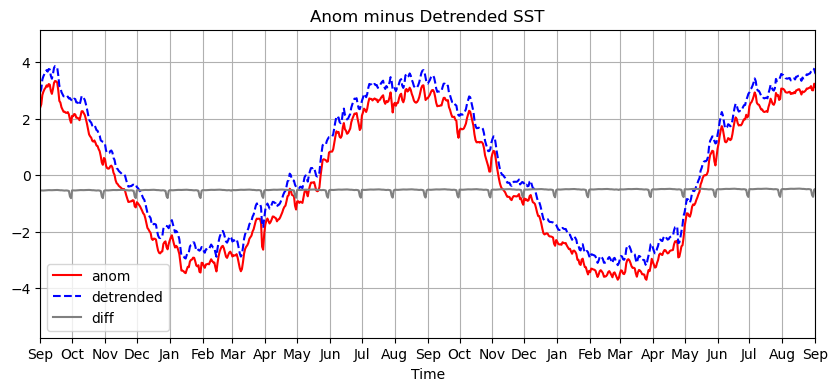

In [16]:
diff = (anom.drop_vars('day') - detrended_intime)
fig, ax = plt.subplots(figsize=(10, 4))
anom.mean(['lat','lon']).plot(label='anom', color='r', ax=ax)
detrended_intime.mean(['lat','lon']).plot(label='detrended', linestyle='dashed', color='b', ax=ax)
diff.mean(['lat','lon']).plot(label='diff', color='grey', ax=ax)
ax.set_xlim(detrended_intime.time[0], detrended_intime.time[365*2])
ax.legend()
ax.grid()
# Set the major locator to show ticks at the beginning of each month
ax.xaxis.set_major_locator(mdates.MonthLocator())
# Set the major formatter to display the month abbreviation
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.title('Anom minus Detrended SST');

> What is captured in the difference between `anom` and `detrended` sst? Detrended takes out a linear warming signal from sst and `anom` represents the deviated SSTs from the average of SST over the whole time period, and includes the linear and nonlinear warming signal. So `no linear warming` minus `linear warming + nonlinear warming` equals ....? Difference captures non-linear variability or periodic deviations.

> Divets at the end of every month. Why does Every March not have a divet? Is anom and detrended array offset by a day?

## Break up data by seasons

In [55]:
def seasons(da):
    DJF = da.where(da.time.dt.month.isin([12, 1, 2]))
    MAM = da.where(da.time.dt.month.isin([3, 4, 5]))
    JJA = da.where(da.time.dt.month.isin([6, 7, 8]))
    SON = da.where(da.time.dt.month.isin([9, 10, 11]))
    seasons_ds = xr.merge([DJF.rename('winter'), MAM.rename('spring'), 
                           JJA.rename('summer'), SON.rename('autmun')])
    return seasons_ds

In [56]:
seasons(oisst)

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 16101, lon: 79, lat: 56)
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon      (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
Data variables:
    winter   (time, lat, lon) float32 285MB nan nan nan nan ... nan nan nan nan
    spring   (time, lat, lon) float32 285MB nan nan nan nan ... nan nan nan nan
    summer   (time, lat, lon) float32 285MB nan nan nan nan ... nan nan nan nan
    autmun   (time, lat, lon) float32 285MB nan nan nan ... 27.57 27.96 28.48
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.82]

In [57]:
clim = oisst_ds.sst.sel(lon=slice(None, 279.625)).groupby('time.dayofyear').mean('time')

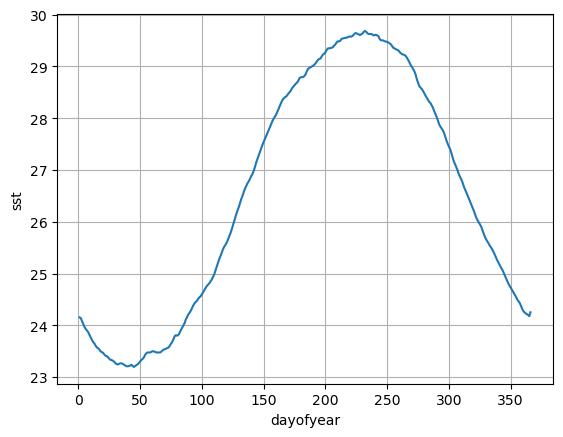

In [58]:
clim.mean(['lat','lon']).plot()
plt.grid()

## 90$^{th}$ Percentile, Duration count

In [5]:
##DETRENDED BLOCK
#Group by day of the year and then calculate the 90th percentile for each day
da_d = detrended_intime.groupby('time.dayofyear')
baseline_p90_d = da_d.quantile(0.9, dim='time') #('dayofyear', 'lat', 'lon'){:366, :56, :79}
#reindex and repeat the baseline_p90 array to match the full dataset's dayofyear
current_p90_threshold_d = baseline_p90_d.sel(dayofyear=oisst_ds.time.dt.dayofyear)#('time', 'lat', 'lon'){:16101, :56, :79}
#Identify temp/days where current temperature exceeds the 90th percentile baseline
exceedance_days_d = detrended_intime.where(detrended_intime > current_p90_threshold_d)
#Make boolean mask of days that exceed 90th percentile
exceedance_mask_bool_d = (detrended_intime > current_p90_threshold_d)
#Make boolean mask to int to count days for 5-day threshold
exceedance_int_d = exceedance_mask_bool_d.astype(int) #0==False, 1==True
#Identify the events that are >=5 days
##consecutive_exceedances_5D_d = exceedance_int_d.rolling(time=5, center=False).sum()
##exceedance_periods_5D_d = consecutive_exceedances_5D_d >= 5

#------------------------------------------------
#function to impose the 5-day duration and 3-day gap criteria
def find_events(arr, min_run=5, gap=3):
    events = []
    current_run_start = None
    last_event_end = None

    for i, val in enumerate(arr):
        if val == 1:
            # Start of a new potential run
            if current_run_start is None:
                current_run_start = i
        else:
            # 0 encountered: finalize current run if valid
            if current_run_start is not None:
                run_length = i - current_run_start

                if run_length >= min_run:
                    # If we have previous event, check gap rule
                    if events:
                        prev_start, prev_end = events[-1]
                        if current_run_start - prev_end >= gap:
                            events.append((current_run_start, i - 1))
                        else:
                            # Merge into previous event
                            events[-1] = (prev_start, i - 1)
                    else:
                        events.append((current_run_start, i - 1))

                current_run_start = None

    # Handle case where array ends with 1-run
    if current_run_start is not None:
        run_length = len(arr) - current_run_start
        if run_length >= min_run:
            if events:
                prev_start, prev_end = events[-1]
                if current_run_start - prev_end >= gap:
                    events.append((current_run_start, len(arr) - 1))
                else:
                    events[-1] = (prev_start, len(arr) - 1)
            else:
                events.append((current_run_start, len(arr) - 1))

    return events

In [8]:
#da that retains temp above 90th percentile and associated coords 
exceedance_days_d

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ..., 1.80490595,
         1.76289759,        nan],
        [       nan,        nan,        nan, ..., 1.85251356,
                nan,        nan],
        [       nan,        nan,        nan, ..., 1.93180052,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
         4.62997146, 4.01023181]]])
Coordinates:
  * time       (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon        (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat        (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile   float64 8B 0.9
    dayofyear  (time) int64 129kB 244 245 246 247 248 ... 269 270 271 272 273

In [9]:
#int boolean da where 1s=above90th, 0s=below90th
exceedance_int_d

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1]]])
Coordinates:
  * time       (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon        (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat        (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile   float64 8B 0.9
    dayofyear  (time) int64 129kB 244 245 246 247 248 ... 269 270 271 272 273

In [9]:
# Count the number of days exceeding the 90th percentile in a specific year:
target_year_exceedances_d = exceedance_days_d.sel(time='2015').count()
print('Number of days exceeding the 90th percentile in \033[1m 2015 \033[0m:' + 
f'\033[1m{target_year_exceedances_d.item():,}\033[0m')

target_year_exceedances_d = exceedance_days_d.sel(time='2020').count()
print('Number of days exceeding the 90th percentile in \033[1m 2020: \033[0m' + 
f'\033[1m{target_year_exceedances_d.item():,}\033[0m')

Number of days exceeding the 90th percentile in  2015 :143,504
Number of days exceeding the 90th percentile in  2020: 139,549


In [10]:
# Example usage of criteria function
arr_example = [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1 ,1 ,1 ,1, 0]
events_example = find_events(arr_example)
print(events_example)
print('Interpretation: \nEvent 1: indices 1 → 6 (6 ones) \nEvent 2: indices 12 → 17 (6 ones)')

[(1, 6), (12, 17)]
Interpretation: 
Event 1: indices 1 → 6 (6 ones) 
Event 2: indices 12 → 17 (6 ones)


In [11]:
#need to map the `events` object back to exceedance_days_d array
#convert events array into int objects that can be used for slicing in consecutive_exceedances_5D_d array
slices = [slice(start, stop) for start, stop in events_example]
slices
[print(arr_example[sl]) for sl in slices]
#next step is to unravel the raveled array

[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]


[None, None]

## To Do (12-10-25 meeting): 
- stacked events bar plot
- Map of avg duration at each grid pt
- Map of total days
- Map of # events
- Map of avg temp anom during events

| Flattening Method                        | Basis        | Guarantee matches xarray? |
| ----------------------------- | ------------ | ------------------------- |
| `.ravel()`                    | memory order | ❌ no                      |
| `.reshape(-1)`                | memory order | ❌ no                      |
| `.transpose(...).reshape(-1)` | index order  | ✅ yes                     |
| `da.stack(...).values`        | index order  | baseline                  |


In [10]:
#test if ravel/tranpose methods yield same output at this step
np.array_equal(exceedance_int_d.values.ravel(),
               exceedance_int_d.transpose('time', 'lat', 'lon').values.reshape(-1))

True

In [13]:
#test if ravel/tranpose methods yield same output at this step
#np.array_equal outputs False even if nans are in the same place, so need to specify extra arg
np.array_equal(exceedance_days_d.values.ravel(),
               exceedance_days_d.transpose('time', 'lat', 'lon').values.reshape(-1),
               equal_nan=True)

True

In [14]:
arr = exceedance_int_d.values.ravel()
events = find_events(arr)
events #list of tuples and pairings of start/stop indices for each event that meets the criteria

[(416, 420),
 (493, 503),
 (569, 584),
 (648, 663),
 (728, 739),
 (811, 816),
 (1396, 1402),
 (1477, 1481),
 (1484, 1489),
 (1564, 1568),
 (3028, 3038),
 (3109, 3117),
 (3189, 3196),
 (3271, 3275),
 (4920, 4927),
 (4999, 5008),
 (5078, 5086),
 (5158, 5162),
 (5820, 5830),
 (5901, 5906),
 (5988, 5992),
 (7156, 7161),
 (7235, 7240),
 (7314, 7318),
 (7393, 7397),
 (7452, 7461),
 (7471, 7476),
 (7531, 7541),
 (7549, 7555),
 (7611, 7621),
 (7630, 7635),
 (7692, 7702),
 (7710, 7714),
 (7772, 7781),
 (7851, 7861),
 (7933, 7940),
 (8031, 8035),
 (9067, 9074),
 (9146, 9153),
 (9224, 9232),
 (9301, 9311),
 (9345, 9351),
 (9380, 9390),
 (9423, 9430),
 (9459, 9468),
 (9537, 9546),
 (9616, 9624),
 (9695, 9702),
 (9775, 9780),
 (9853, 9858),
 (9933, 9937),
 (10165, 10169),
 (10244, 10249),
 (10321, 10336),
 (10399, 10416),
 (10477, 10488),
 (10555, 10566),
 (10637, 10649),
 (10710, 10731),
 (10795, 10814),
 (10874, 10901),
 (10953, 10967),
 (10971, 10979),
 (11021, 11027),
 (11033, 11046),
 (11051, 

In [15]:
arr

array([0, 0, 0, ..., 0, 1, 1])

In [16]:
masked = np.full(arr.shape, np.nan) 
for start, stop in events:
    masked[start:stop] = arr[start:stop] #keep only event values

masked_temps = np.full(exceedance_days_d.values.ravel().shape, np.nan) 
for start, stop in events:
    masked_temps[start:stop] = exceedance_days_d.values.ravel()[start:stop] #keep only events' temp values

In [17]:
masked_temps.shape

(71230824,)

In [18]:
#test if unraveling works here
np.array_equal(exceedance_int_d, arr.reshape(*exceedance_int_d.shape))

True

In [19]:
masked_bool_3D = masked.reshape(*exceedance_int_d.shape)
masked_temp_3D = masked_temps.reshape(*exceedance_days_d.shape)

In [20]:
masked_bool_da = xr.DataArray(data=masked_bool_3D, coords={'time':exceedance_int_d.time, 
                                                           'lat':exceedance_int_d.lat,
                                                           'lon':exceedance_int_d.lon})
masked_temp_da = xr.DataArray(data=masked_temp_3D, coords={'time':exceedance_days_d.time, 
                                                           'lat':exceedance_days_d.lat,
                                                           'lon':exceedance_days_d.lon})

In [21]:
masked_bool_3D

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,  1., nan, nan

In [22]:
masked_temp_da

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
  * lon      (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6

In [23]:
#Sum up all the days that exceed 90th/5-day/3-day threshold in each year
yrs_list = np.unique(masked_bool_da.time.dt.year)
exceedance_days_by_yr = []
for year in yrs_list:
    exceedance_days_by_yr.append(masked_bool_da.sel(time=f'{year}').count())

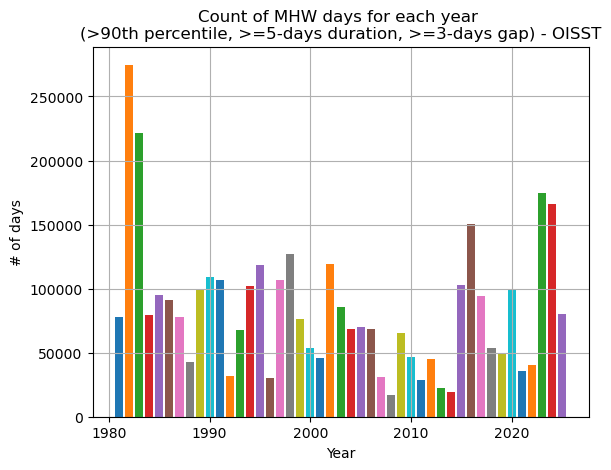

In [24]:
from tqdm import tqdm
#for i in tqdm(np.arange(0, len(events))):
#    plt.bar(i, events[i][-1] - events[i][0])
for (year, exc_days) in zip(yrs_list, exceedance_days_by_yr):
    plt.bar(year, exc_days)
plt.ylabel('# of days')
plt.xlabel('Year')
#plt.ylim(0, 600000)
#plt.xlim(1980, 2026)
plt.title('Count of MHW days for each year \n(>90th percentile, >=5-days duration, >=3-days gap) - OISST')
plt.grid();

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="year", y="MHW events", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [38]:
#Sum up all the days that exceed 90th/5-day threshold in each year
yrs_list = np.unique(masked_temp_da.time.dt.year)
exceedance_cumsum_by_yr = []
for year in yrs_list:
    exceedance_cumsum_by_yr.append(masked_temp_da.sel(time=f'{year}').count())

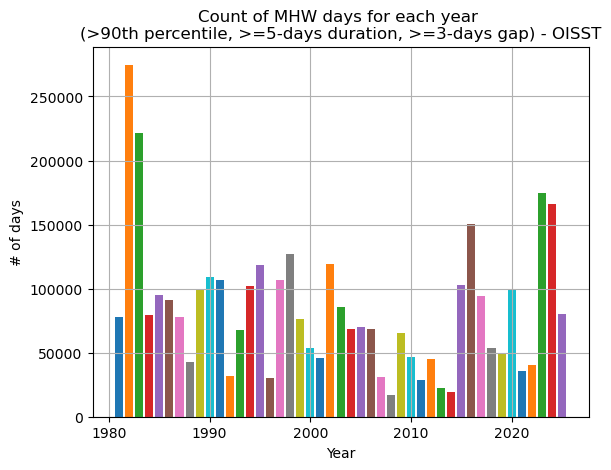

In [39]:
from tqdm import tqdm
#for i in tqdm(np.arange(0, len(events))):
#    plt.bar(i, events[i][-1] - events[i][0])
for (year, exc_days) in zip(yrs_list, exceedance_days_by_yr):
    plt.bar(year, exc_days)
plt.ylabel('# of days')
plt.xlabel('Year')
#plt.ylim(0, 600000)
#plt.xlim(1980, 2026)
plt.title('Count of MHW days for each year \n(>90th percentile, >=5-days duration, >=3-days gap) - OISST')
plt.grid();

In [100]:
nan_array = np.full(exceedance_int_d.shape, np.nan)
nan_arr_flat = nan_array.ravel()
nan_arr_flat

array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:
nan_arr_flat[:] = events

In [91]:
arr_index = np.arange(0, len(arr))

In [95]:
arr_index[416:420]

array([416, 417, 418, 419])

In [ ]:
arr

**Goals:**
1. Duration count for each event (bar plot)
> Map it back to get time coords
2. Identify the temperatures for each event (line/bar plot)

In [55]:
slices = [slice(start, stop) for start, stop in events[:1]]
slices
[print(arr[sl]) for sl in slices]

[1 1 1 1]


[None]

In [59]:
slices

[slice(416, 420, None)]

In [57]:
slice(events[0])

slice(None, (416, 420), None)

In [25]:
events[:3]

[(416, 420), (493, 503), (569, 584)]

In [26]:
eventID = [i for i, _ in enumerate(events)] #same len as `events`

In [27]:
eventID

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [28]:
events

[(416, 420),
 (493, 503),
 (569, 584),
 (648, 663),
 (728, 739),
 (811, 816),
 (1396, 1402),
 (1477, 1481),
 (1484, 1489),
 (1564, 1568),
 (3028, 3038),
 (3109, 3117),
 (3189, 3196),
 (3271, 3275),
 (4920, 4927),
 (4999, 5008),
 (5078, 5086),
 (5158, 5162),
 (5820, 5830),
 (5901, 5906),
 (5988, 5992),
 (7156, 7161),
 (7235, 7240),
 (7314, 7318),
 (7393, 7397),
 (7452, 7461),
 (7471, 7476),
 (7531, 7541),
 (7549, 7555),
 (7611, 7621),
 (7630, 7635),
 (7692, 7702),
 (7710, 7714),
 (7772, 7781),
 (7851, 7861),
 (7933, 7940),
 (8031, 8035),
 (9067, 9074),
 (9146, 9153),
 (9224, 9232),
 (9301, 9311),
 (9345, 9351),
 (9380, 9390),
 (9423, 9430),
 (9459, 9468),
 (9537, 9546),
 (9616, 9624),
 (9695, 9702),
 (9775, 9780),
 (9853, 9858),
 (9933, 9937),
 (10165, 10169),
 (10244, 10249),
 (10321, 10336),
 (10399, 10416),
 (10477, 10488),
 (10555, 10566),
 (10637, 10649),
 (10710, 10731),
 (10795, 10814),
 (10874, 10901),
 (10953, 10967),
 (10971, 10979),
 (11021, 11027),
 (11033, 11046),
 (11051, 

In [29]:
masked_temps

array([nan, nan, nan, ..., nan, nan, nan])

In [30]:
masked_temp_da

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * time     (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lat      (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
  * lon      (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6

In [34]:
#test if stack method yields same output as original flattening using ravel
np.array_equal(masked_temp_da.stack(z=('time', 'lat', 'lon')), masked_temp_da.values.ravel(), 
               equal_nan=True)

True

In [35]:
#how to flatten masked_temp_da and retain time dim associated w each grid cell
flattened = masked_temp_da.stack(z=('time', 'lat', 'lon'))

values = flattened.values # flattened numerical data
event_time_coord = flattened['z'] # MultiIndex with (time, lat, lon)

In [40]:
flattened

<xarray.DataArray (z: 71230824)> Size: 570MB
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * z        (z) object 570MB MultiIndex
  * time     (z) datetime64[ns] 570MB 1981-09-01 1981-09-01 ... 2025-09-30
  * lat      (z) float32 285MB 17.12 17.12 17.12 17.12 ... 30.88 30.88 30.88
  * lon      (z) float32 285MB 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6

In [46]:
event_time_coord

<xarray.DataArray 'z' (z: 71230824)> Size: 570MB
array([(Timestamp('1981-09-01 00:00:00'), 17.125, 260.125),
       (Timestamp('1981-09-01 00:00:00'), 17.125, 260.375),
       (Timestamp('1981-09-01 00:00:00'), 17.125, 260.625), ...,
       (Timestamp('2025-09-30 00:00:00'), 30.875, 279.125),
       (Timestamp('2025-09-30 00:00:00'), 30.875, 279.375),
       (Timestamp('2025-09-30 00:00:00'), 30.875, 279.625)], dtype=object)
Coordinates:
  * z        (z) object 570MB MultiIndex
  * time     (z) datetime64[ns] 570MB 1981-09-01 1981-09-01 ... 2025-09-30
  * lat      (z) float32 285MB 17.12 17.12 17.12 17.12 ... 30.88 30.88 30.88
  * lon      (z) float32 285MB 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6

In [36]:
values

array([nan, nan, nan, ..., nan, nan, nan])

In [38]:
#test to be sure
np.array_equal(masked_temps, values, equal_nan=True)

True

In [41]:
len(values)

71230824

In [43]:
len(event_time_coord)

71230824

In [44]:
len(masked_temps)

71230824

In [ ]:
#time-year; temps; event ID
df = pd.DataFrame({
    "time": event_time_coord,
    "event_id": eventID,
    "temp": masked_temp
})

100%|██████████| 367388/367388 [04:36<00:00, 1330.20it/s]


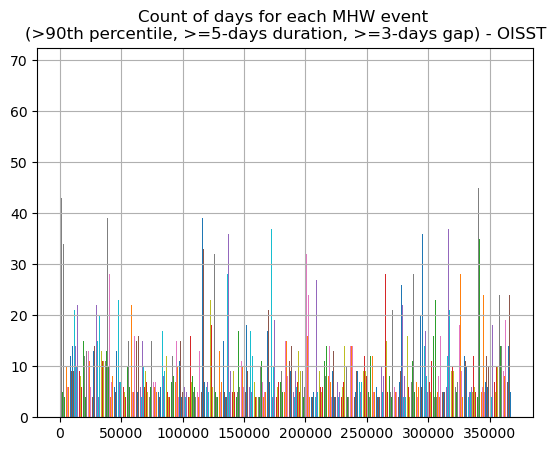

In [40]:
from tqdm import tqdm
for i in tqdm(np.arange(0, len(events))):
    plt.bar(i, events[i][-1] - events[i][0])
plt.title('Count of days for each MHW event \n(>90th percentile, >=5-days duration, >=3-days gap) - OISST')
plt.grid();
#Each event does not exceed 50 days - don't know when/where these events occur though

In [26]:
arr_example

[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]

In [28]:
exceedance_int_d

<xarray.DataArray (time: 16101, lat: 56, lon: 79)> Size: 570MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1]]])
Coordinates:
  * time       (time) datetime64[ns] 129kB 1981-09-01 1981-09-02 ... 2025-09-30
  * lon        (lon) float32 316B 260.1 260.4 260.6 260.9 ... 279.1 279.4 279.6
  * lat        (lat) float32 224B 17.12 17.38 17.62 17.88 ... 30.38 30.62 30.88
    quantile   float64 8B 0.9
    dayofyear  (time) int64 129kB 244 245 246 247 248 ... 269 270 271 272 273

In [30]:
arr

array([0, 0, 0, ..., 0, 1, 1])

In [34]:
#check if unraveling this way outputs original array
np.array_equal(exceedance_int_d, arr.reshape(*exceedance_int_d.shape))

True

In [22]:
#Absolute Temp block
#Group by day of the year and then calculate the 90th percentile
da = oisst_ds.sst.sel(lon=slice(None, 279.625)).groupby('time.dayofyear')
baseline_p90 = da.quantile(0.9, dim='time')

#reindex the baseline_p90 to match the full dataset's dayofyear
current_p90_threshold = baseline_p90.sel(dayofyear=oisst_ds.time.dt.dayofyear)

#Identify days where current temperature exceeds the 90th percentile baseline
exceedance_days = oisst_ds.sst.where(oisst_ds.sst > current_p90_threshold)
#Make boolean mask of days that exceed 90th percentile
exceedance_mask_bool = (oisst_ds.sst > current_p90_threshold)
#Make boolean mask int to count days for 5-day threshold
exceedance_int = exceedance_mask_bool.astype(int)
#Identify the events that are >=5 days
consecutive_exceedances_5D = exceedance_int.rolling(time=5, center=False).sum()
exceedance_periods_5D = consecutive_exceedances_5D >= 5
consecutive_exceedances_30D = exceedance_int.rolling(time=30, center=False).sum()
exceedance_periods_30D = consecutive_exceedances_30D >= 30

# Count the number of days exceeding the 90th percentile in a specific year:
target_year_exceedances = exceedance_days.sel(time='2015').count()
print('Number of days exceeding the 90th percentile in \033[1m 2015 \033[0m:' + 
f'\033[1m{target_year_exceedances.item():,}\033[0m')

target_year_exceedances = exceedance_days.sel(time='2020').count()
print('Number of days exceeding the 90th percentile in \033[1m 2020: \033[0m' + 
f'\033[1m{target_year_exceedances.item():,}\033[0m')

Number of days exceeding the 90th percentile in  2015 :218,905
Number of days exceeding the 90th percentile in  2020: 299,701


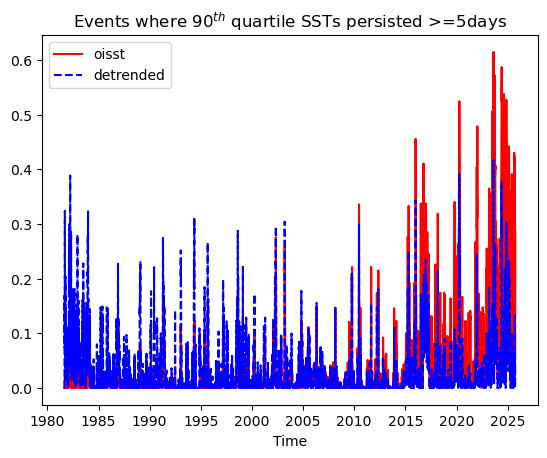

In [23]:
exceedance_periods_5D.mean(['lat', 'lon']).plot(label='oisst', color='r')
exceedance_periods_5D_d.mean(['lat', 'lon']).plot(label='detrended', color='b', linestyle='dashed')
plt.legend()
plt.title('Events where 90$^{th}$ quartile SSTs persisted >=5days');

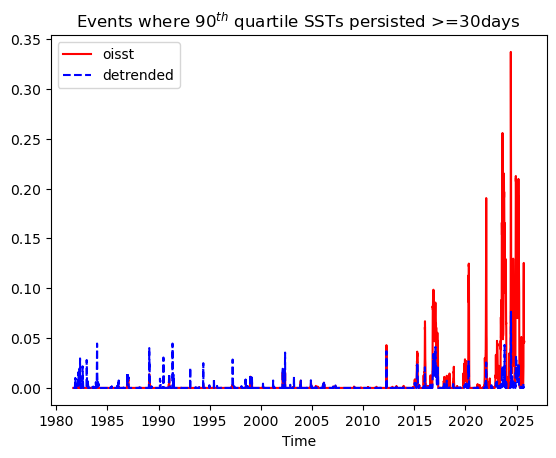

In [24]:
exceedance_periods_30D.mean(['lat', 'lon']).plot(label='oisst', color='r')
exceedance_periods_30D_d.mean(['lat', 'lon']).plot(label='detrended', color='b', linestyle='dashed')
plt.legend()
plt.title('Events where 90$^{th}$ quartile SSTs persisted >=30days');

In [25]:
#Sum up all the days that exceed 90th/5-day threshold in each year
yrs_list = np.unique(exceedance_days.time.dt.year)
exceedance_days_by_yr = []
for year in yrs_list:
    exceedance_days_by_yr.append(exceedance_days.sel(time=f'{year}').count())

In [26]:
exceedance_days.sel(time='2012').count()

<xarray.DataArray 'sst' ()> Size: 8B
array(100532)
Coordinates:
    quantile  float64 8B 0.9

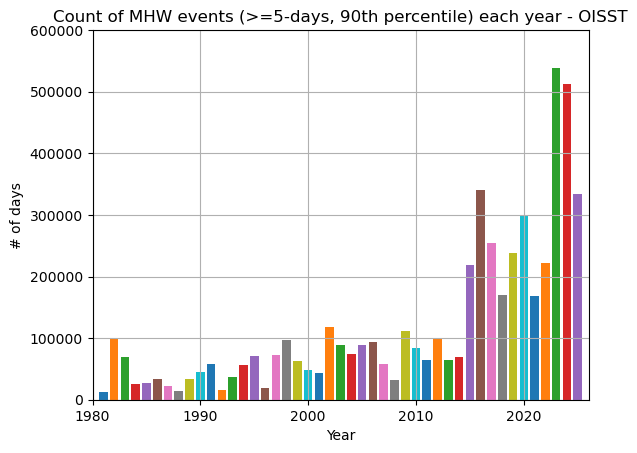

In [27]:
for (year, exc_days) in zip(yrs_list, exceedance_days_by_yr):
    plt.bar(year, exc_days)
plt.ylabel('# of days')
plt.xlabel('Year')
plt.ylim(0, 600000)
plt.xlim(1980, 2026)
plt.title('Count of MHW events (>=5-days, 90th percentile) each year - OISST')
plt.grid();

In [66]:
#Sum up all the days that exceed 90th/5-day threshold in each year
yrs_list = np.unique(event_id.time.dt.year)
exceedance_events_by_yr = []
for year in yrs_list:
    exceedance_events_by_yr.append(event_id.sel(time=f'{year}').count())

In [80]:
format(event_id.sel(time='2015').count(), ",") 

'1,614,760'

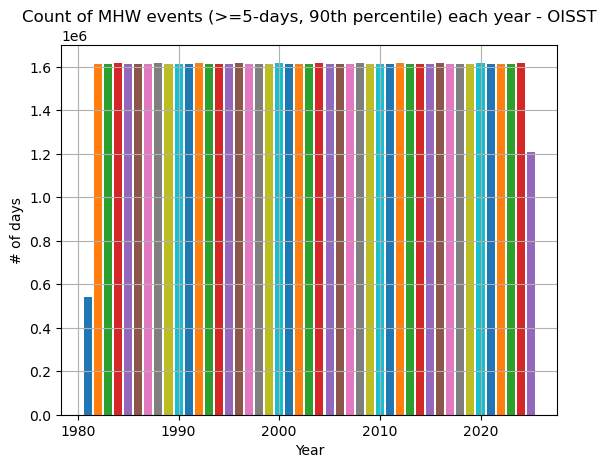

In [82]:
for (year, exc_events) in zip(yrs_list, exceedance_events_by_yr):
    plt.bar(year, exc_events)
plt.ylabel('# of days')
plt.xlabel('Year')
#plt.ylim(0, 600000)
#plt.xlim(1980, 2026)
plt.title('Count of MHW events (>=5-days, 90th percentile) each year - OISST')
plt.grid();

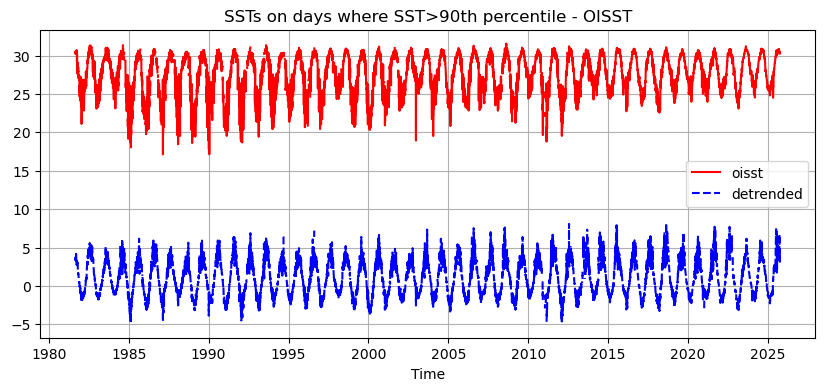

In [30]:
exceedance_days.mean(['lat', 'lon']).plot(label='oisst', color='r', figsize=(10,4))
exceedance_days_d.mean(['lat', 'lon']).plot(label='detrended', color='b', linestyle='dashed')
plt.grid()
#plt.ylim(17,32)
plt.title('SSTs on days where SST>90th percentile - OISST')
plt.legend(loc='best');